In [164]:
!pip install kneed

In [238]:
! pip install scikitplot

ERROR: Could not find a version that satisfies the requirement scikitplot (from versions: none)
ERROR: No matching distribution found for scikitplot


In [224]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  roc_curve, auc
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.decomposition import PCA

In [168]:
# Load the dataset
df = pd.read_csv("marketing_campaign3.csv")

In [170]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [172]:
# Remove redundant columns
df.drop(columns=["Z_CostContact", "Z_Revenue", "ID"], inplace=True)

In [174]:
# Convert Year_Birth to Age
df["Age"] = datetime.now().year - df["Year_Birth"]
df.drop(columns=["Year_Birth"], inplace=True)

In [176]:
# Encode Education as ordinal
education_order = {"Basic": 0, "2n Cycle": 1, "Graduation": 2, "Master": 3, "PhD": 4}
df["Education"] = df["Education"].map(education_order)

In [178]:
# Combine Kidhome and Teenhome into one feature 'Children'
df["Children"] = df["Kidhome"] + df["Teenhome"]
df.drop(columns=["Kidhome", "Teenhome"], inplace=True)

In [180]:
# Convert Dt_Customer to Customer_Since_Days (days since registration)
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format="%d-%m-%Y")
df["Customer_Since_Days"] = (datetime.now() - df["Dt_Customer"]).dt.days
df.drop(columns=["Dt_Customer"], inplace=True)

In [182]:
# Group Marital Status into fewer categories
marital_map = {
    "Single": "Single",
    "Married": "Married",
    "Together": "Married",
    "Divorced": "Separated",
    "Widow": "Separated",
    "Alone": "Separated",
    "Absurd": "Other",
    "YOLO": "Other",
}
df["Marital_Status"] = df["Marital_Status"].map(marital_map)

# Encode Marital_Status
df["Marital_Status"] = LabelEncoder().fit_transform(df["Marital_Status"])

In [184]:
# Impute missing values in Income with median
df["Income"].fillna(df["Income"].median(), inplace=True)

C:\Users\prash\AppData\Local\Temp\ipykernel_17268\197693381.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Income"].fillna(df["Income"].median(), inplace=True)


In [186]:
# Identify and remove outliers in Income using IQR
Q1 = df["Income"].quantile(0.25)
Q3 = df["Income"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df["Income"] >= lower_bound) & (df["Income"] <= upper_bound)]

In [188]:
#Create shopping behavior features
df["Total_Spending"] = df[["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]].sum(axis=1)
df["Spending_Per_Visit"] = df["Total_Spending"] / (df["NumWebVisitsMonth"] + 1)

In [190]:
# Create purchase behavior features
df["Total_Purchases"] = df[["NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"]].sum(axis=1)
df["Web_Purchase_Ratio"] = df["NumWebPurchases"] / (df["Total_Purchases"] + 1)

In [192]:
# Create campaign engagement features
df["Total_Accepted_Campaigns"] = df[["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]].sum(axis=1)
df["Loyal_Customer"] = (df["Total_Accepted_Campaigns"] > 2).astype(int)

In [194]:
# Scale numerical features
num_features = ["Income", "Age", "Customer_Since_Days", "Total_Spending", "Spending_Per_Visit", "Total_Purchases", "Web_Purchase_Ratio"]
scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])

In [198]:
# Display processed data info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 2232 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Education                 2232 non-null   int64  
 1   Marital_Status            2232 non-null   int32  
 2   Income                    2232 non-null   float64
 3   Recency                   2232 non-null   int64  
 4   MntWines                  2232 non-null   int64  
 5   MntFruits                 2232 non-null   int64  
 6   MntMeatProducts           2232 non-null   int64  
 7   MntFishProducts           2232 non-null   int64  
 8   MntSweetProducts          2232 non-null   int64  
 9   MntGoldProds              2232 non-null   int64  
 10  NumDealsPurchases         2232 non-null   int64  
 11  NumWebPurchases           2232 non-null   int64  
 12  NumCatalogPurchases       2232 non-null   int64  
 13  NumStorePurchases         2232 non-null   int64  
 14  NumWebVisitsM

In [200]:
df.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Response,Age,Children,Customer_Since_Days,Total_Spending,Spending_Per_Visit,Total_Purchases,Web_Purchase_Ratio,Total_Accepted_Campaigns,Loyal_Customer
0,2,3,0.315922,58,635,88,546,172,88,88,...,1,0.983726,0,1.530417,1.682002,0.238594,1.330482,0.658038,0,0
1,2,3,-0.256684,38,11,1,6,2,1,6,...,0,1.233983,2,-1.189828,-0.962227,-0.698008,-1.162585,-1.098372,0,0
2,2,0,0.970142,26,426,49,127,111,21,42,...,0,0.316372,0,-0.205594,0.283388,0.016203,0.805626,1.254153,0,0
3,2,0,-1.213033,26,11,4,20,10,3,5,...,0,-1.268592,1,-1.061234,-0.918988,-0.683452,-0.900156,-0.252693,0,0
4,4,0,0.323448,94,173,43,118,46,27,15,...,0,-1.018334,1,-0.952424,-0.305328,-0.386005,0.543198,0.043294,0,0


In [202]:
# Scale numerical features
num_features = ["Income", "Age", "Customer_Since_Days", "Total_Spending", "Spending_Per_Visit", "Total_Purchases", "Web_Purchase_Ratio"]
scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])

In [204]:
df.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Response,Age,Children,Customer_Since_Days,Total_Spending,Spending_Per_Visit,Total_Purchases,Web_Purchase_Ratio,Total_Accepted_Campaigns,Loyal_Customer
0,2,3,0.315922,58,635,88,546,172,88,88,...,1,0.983726,0,1.530417,1.682002,0.238594,1.330482,0.658038,0,0
1,2,3,-0.256684,38,11,1,6,2,1,6,...,0,1.233983,2,-1.189828,-0.962227,-0.698008,-1.162585,-1.098372,0,0
2,2,0,0.970142,26,426,49,127,111,21,42,...,0,0.316372,0,-0.205594,0.283388,0.016203,0.805626,1.254153,0,0
3,2,0,-1.213033,26,11,4,20,10,3,5,...,0,-1.268592,1,-1.061234,-0.918988,-0.683452,-0.900156,-0.252693,0,0
4,4,0,0.323448,94,173,43,118,46,27,15,...,0,-1.018334,1,-0.952424,-0.305328,-0.386005,0.543198,0.043294,0,0


In [206]:
# Save the processed dataset
df.to_csv("processed_marketing_campaign.csv", index=False)

In [208]:
# Define target variable (response to campaign)
df["Response"] = df["Response"].astype(int)
X = df.drop(columns=["Response"])
y = df["Response"]

In [210]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [212]:
# Train and evaluate models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost" : XGBClassifier()
}

In [214]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.8904
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       378
           1       0.71      0.49      0.58        69

    accuracy                           0.89       447
   macro avg       0.81      0.73      0.76       447
weighted avg       0.88      0.89      0.88       447

[[364  14]
 [ 35  34]]
Decision Tree Accuracy: 0.8456
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       378
           1       0.50      0.46      0.48        69

    accuracy                           0.85       447
   macro avg       0.70      0.69      0.70       447
weighted avg       0.84      0.85      0.84       447

[[346  32]
 [ 37  32]]
Random Forest Accuracy: 0.8635
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       378
           1       0.63      0.28      0.38        69

    accuracy                         

In [216]:
# Define models and hyperparameters for Grid Search
param_grid = {
    "Logistic Regression": (LogisticRegression(), {"C": [0.01, 0.1, 1, 10]}),
    "Decision Tree": (DecisionTreeClassifier(), {"max_depth": [3, 5, 10, None], "min_samples_split": [2, 5, 10]}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 10, None]}),
    "Gradient Boosting": (GradientBoostingClassifier(), {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]})
}

In [218]:
# Perform Grid Search for each model
best_models = {}
for name, (model, params) in param_grid.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    y_pred = grid_search.best_estimator_.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best parameters for Logistic Regression: {'C': 0.1}
Logistic Regression Accuracy: 0.8949
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       378
           1       0.75      0.48      0.58        69

    accuracy                           0.89       447
   macro avg       0.83      0.72      0.76       447
weighted avg       0.89      0.89      0.88       447

Best parameters for Decision Tree: {'max_depth': 3, 'min_samples_split': 2}
Decision Tree Accuracy: 0.8523
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       378
           1       0.56      0.22      0.31        69

    accuracy                           0.85       447
   macro avg       0.71      0.59      0.61       447
weighted avg       0.82      0.85      0.82       447

Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
Random Forest Accuracy: 0.8747
              precision    recall  f1-score

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature Importance (Logistic Regression Coefficients):
 Total_Accepted_Campaigns    1.399127
Total_Purchases             1.082595
AcceptedCmp3                0.854105
Customer_Since_Days         0.798631
Total_Spending              0.593313
Education                   0.561921
Web_Purchase_Ratio          0.485646
Marital_Status              0.422775
Income                      0.416021
AcceptedCmp5                0.408380
AcceptedCmp2                0.264845
AcceptedCmp1                0.150901
NumWebVisitsMonth           0.149088
Loyal_Customer              0.114419
NumDealsPurchases           0.047271
NumCatalogPurchases         0.024415
Complain                    0.008974
MntMeatProducts             0.001476
MntGoldProds                0.000423
MntFruits                  -0.000555
MntWines                   -0.002031
MntSweetProducts           -0.002294
MntFishProducts            -0.002662
Age                        -0.027338
Recency                    -0.030897
Spending_Per_Visit 

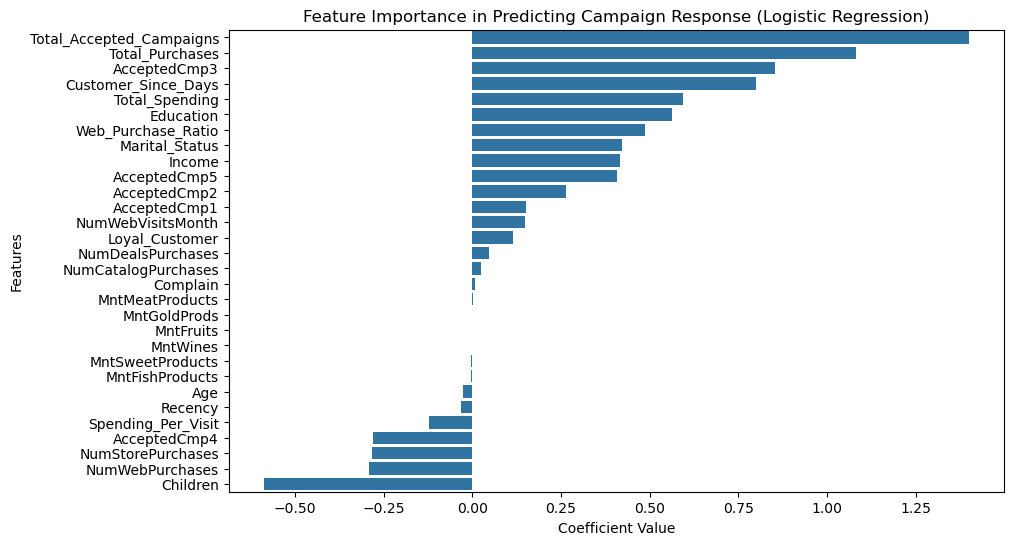

In [220]:
# Train the best model (Logistic Regression as best-performing)
best_model = LogisticRegression(max_iter=1000, random_state=42)
best_model.fit(X_train, y_train)

# Get feature coefficients
feature_importance = pd.Series(best_model.coef_[0], index=X.columns).sort_values(ascending=False)
print("Feature Importance (Logistic Regression Coefficients):\n", feature_importance)

# Plot feature coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance in Predicting Campaign Response (Logistic Regression)")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.show()

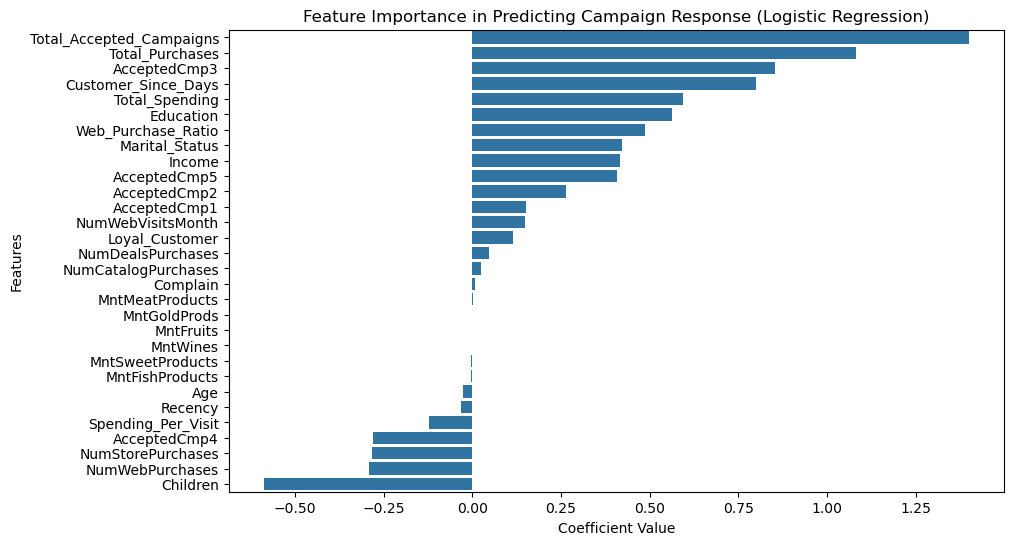

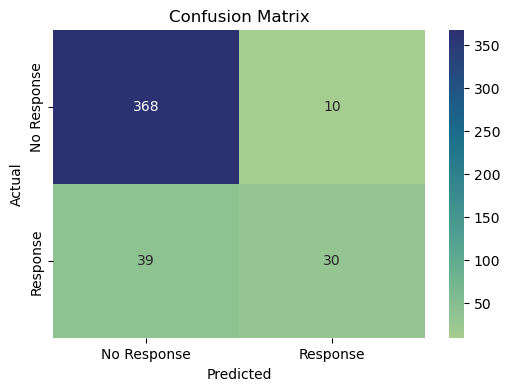

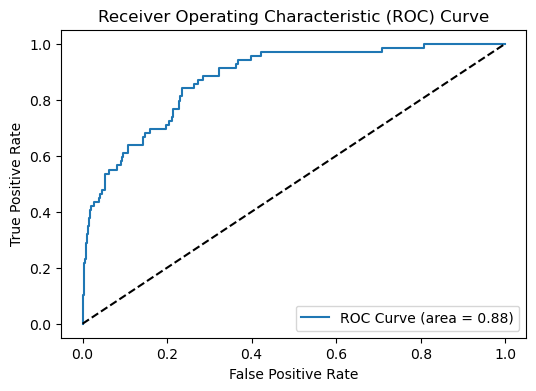

In [138]:
# Plot feature coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance in Predicting Campaign Response (Logistic Regression)")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.show()

# Confusion Matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=['No Response', 'Response'], yticklabels=['No Response', 'Response'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
y_probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\prash\AppData\Local\Temp\ipykernel_17268\2570254403.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_importance.index, palette=colors)


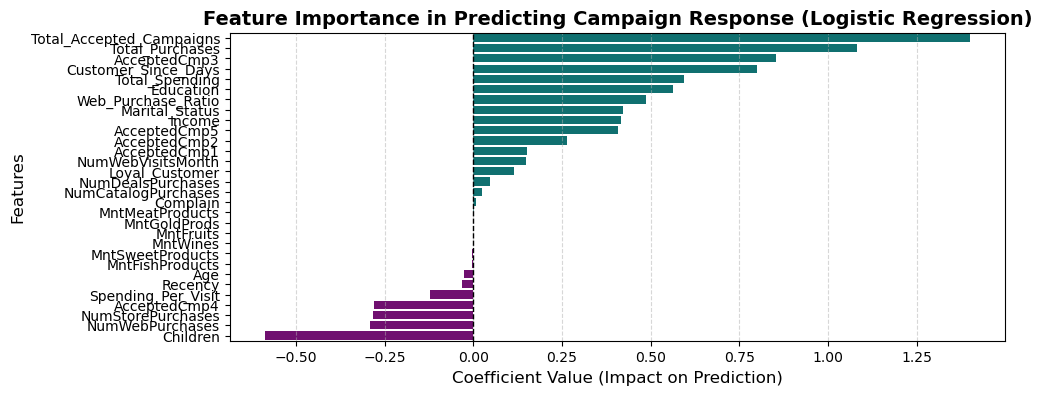

In [236]:
# Train the best model
best_model = LogisticRegression(max_iter=1000, random_state=42)
best_model.fit(X_train, y_train)

# Get feature coefficients
feature_importance = pd.Series(best_model.coef_[0], index=X.columns).sort_values(ascending=False)

# Define colors: Positive (Teal) & Negative (Purple)
colors = ['teal' if val > 0 else 'purple' for val in feature_importance]

# Create the plot
plt.figure(figsize=(10, 4))
sns.barplot(x=feature_importance, y=feature_importance.index, palette=colors)

# Improve aesthetics
plt.title("Feature Importance in Predicting Campaign Response (Logistic Regression)", fontsize=14, fontweight='bold')
plt.xlabel("Coefficient Value (Impact on Prediction)", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.axvline(0, color='black', linestyle='--', linewidth=1)  # Reference line at 0
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

C:\Users\prash\AppData\Local\Temp\ipykernel_17268\2030545055.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Response'] == 1]['Spending_Per_Visit'], label='Responded', shade=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_17268\2030545055.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Response'] == 0]['Spending_Per_Visit'], label='Did Not Respond', shade=True)


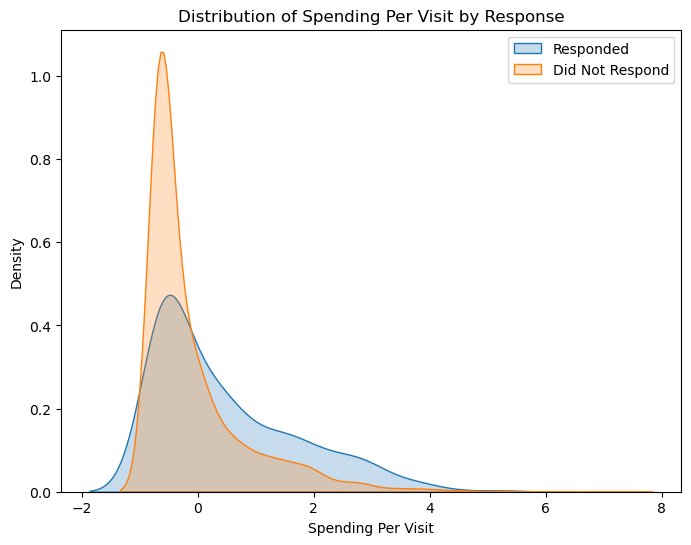

In [230]:
# KDE plot for Spending per Visit
plt.figure(figsize=(8, 6))
sns.kdeplot(df[df['Response'] == 1]['Spending_Per_Visit'], label='Responded', shade=True)
sns.kdeplot(df[df['Response'] == 0]['Spending_Per_Visit'], label='Did Not Respond', shade=True)
plt.title("Distribution of Spending Per Visit by Response")
plt.xlabel("Spending Per Visit")
plt.ylabel("Density")
plt.legend()
plt.show()

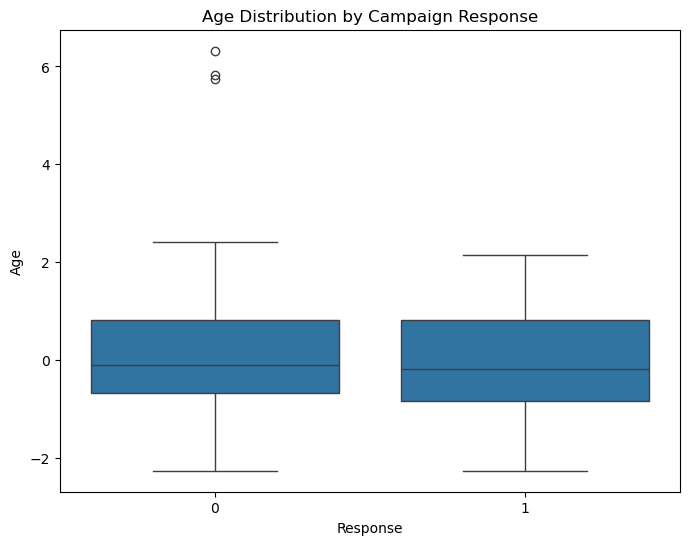

In [232]:
# Boxplot for Age vs Response
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Response'], y=df['Age'])
plt.title("Age Distribution by Campaign Response")
plt.xlabel("Response")
plt.ylabel("Age")
plt.show()

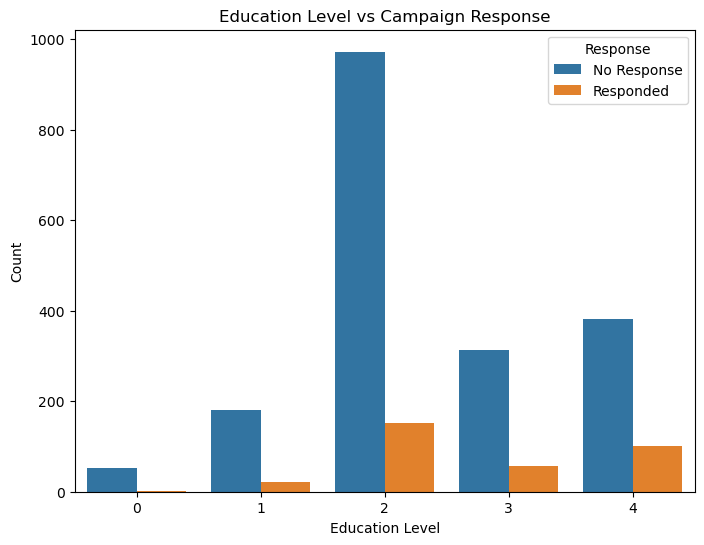

In [234]:
# Countplot for Education vs Response
plt.figure(figsize=(8, 6))
sns.countplot(x=df['Education'], hue=df['Response'])
plt.title("Education Level vs Campaign Response")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.legend(title="Response", labels=["No Response", "Responded"])
plt.show()

C:\Users\prash\AppData\Local\Temp\ipykernel_17268\790147099.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Response'] == 1]['Web_Purchase_Ratio'], label='Responded', shade=True)
C:\Users\prash\AppData\Local\Temp\ipykernel_17268\790147099.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Response'] == 0]['Web_Purchase_Ratio'], label='Did Not Respond', shade=True)


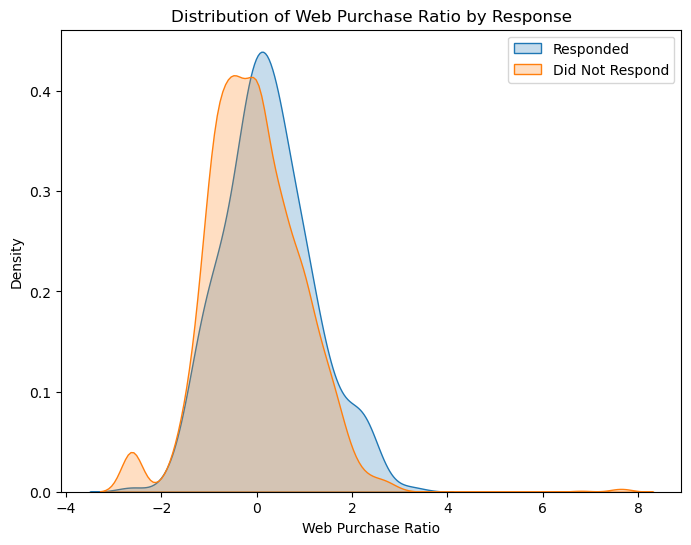

In [158]:
plt.figure(figsize=(8, 6))
sns.kdeplot(df[df['Response'] == 1]['Web_Purchase_Ratio'], label='Responded', shade=True)
sns.kdeplot(df[df['Response'] == 0]['Web_Purchase_Ratio'], label='Did Not Respond', shade=True)
plt.title("Distribution of Web Purchase Ratio by Response")
plt.xlabel("Web Purchase Ratio")
plt.ylabel("Density")
plt.legend()
plt.show()